In [375]:
# Импорт необходимых библиотек
import torch
import torchaudio
import torchaudio.transforms as transforms
import os
import random
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [376]:
# Определение устройства (CPU или GPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Обучение идёт на GPU")
else:
    device = torch.device("cpu")
    print("Обучение идёт на CPU")

Обучение идёт на GPU


In [377]:
import wandb

In [378]:
wandb.init(project="speaker-verification", entity="balamytin-susu")

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁███████████████████████████████████████
epoch,200
train_loss,0.5
val_loss,0.5


In [379]:
# Путь к папке с аудиофайлами (обновите на правильный путь к директории)
data_dir = r'C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\Нейросетевые технологии в задачах синтетических медиа\Практическая 3\VCTK-Corpus\wav48' 


In [380]:
# Получаем все файлы и их соответствующие спикеры
all_files = []
labels = []

for speaker_folder in os.listdir(data_dir):
    speaker_path = os.path.join(data_dir, speaker_folder)
    if os.path.isdir(speaker_path):
        for file_name in os.listdir(speaker_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(speaker_path, file_name)
                all_files.append(file_path)
                labels.append(speaker_folder)  # Лейбл - имя папки спикера

In [381]:
# Выводим результат
print(f"Найдено файлов: {len(all_files)}")
print(f"Пример файла: {all_files[0]}")

Найдено файлов: 44242
Пример файла: C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\Нейросетевые технологии в задачах синтетических медиа\Практическая 3\VCTK-Corpus\wav48\p225\p225_001.wav


In [382]:
# Разделение данных на тренировочные, валидационные и тестовые наборы
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, labels, test_size=0.3, random_state=42, stratify=labels)

val_files, test_files, val_labels, test_labels = train_test_split(
    test_files, test_labels, test_size=0.5, random_state=42, stratify=test_labels)

# Проверяем количество файлов в наборах
print(f"Training set: {len(train_files)} samples")
print(f"Validation set: {len(val_files)} samples")
print(f"Test set: {len(test_files)} samples")

Training set: 30969 samples
Validation set: 6636 samples
Test set: 6637 samples


In [383]:
# Настройки мел-спектрограммы
n_fft = 1024  # Размер окна Фурье
hop_length = 512  # Шаг окна
n_mels = 80  # Количество фильтров мел-банки
sample_rate = 22050  # Частота дискретизации аудиофайлов в VCTK


In [384]:
# Функция для извлечения мел-спектрограммы
mel_transform = transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

In [385]:
def extract_mel_spectrogram(file_path, max_length=285):
    waveform, sr = torchaudio.load(file_path)  # Загружаем аудио
    if sr != sample_rate:
        resample_transform = transforms.Resample(sr, sample_rate)
        waveform = resample_transform(waveform)  # Применяем ресэмплинг
    mel_spec = mel_transform(waveform)  # Извлекаем мел-спектрограмму
    mel_spec_db = transforms.AmplitudeToDB()(mel_spec)  # Преобразуем в dB
    
    # Обрезаем или дополняем мел-спектрограмму до фиксированной длины
    if mel_spec_db.shape[-1] > max_length:
        mel_spec_db = mel_spec_db[:, :, :max_length]
    elif mel_spec_db.shape[-1] < max_length:
        pad_amount = max_length - mel_spec_db.shape[-1]
        mel_spec_db = torch.nn.functional.pad(mel_spec_db, (0, pad_amount))
    
    return mel_spec_db

In [386]:
import torch.nn.functional as F
import torch.nn as nn

class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),  # BatchNorm слой
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),  # BatchNorm слой
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        self.conv3 = nn.Sequential(  # Дополнительный свёрточный слой
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),  # BatchNorm слой
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 10 * 35, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(256, 64)  # Выходной слой - вектор признаков

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)  # Обработка третьим свёрточным слоем
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = nn.functional.normalize(x, p=2, dim=1)  # L2-нормализация
        return x

In [387]:
# import torch.nn.functional as F

# # Определение модели CNN-энкодера
# class CNNEncoder(nn.Module):
#     def __init__(self):
#         super(CNNEncoder, self).__init__()
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=1)
#         self.pool1 = nn.MaxPool2d((2, 2))
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
#         self.pool2 = nn.MaxPool2d((2, 2))
#         self.conv3 = nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1)
#         self.pool3 = nn.MaxPool2d((2, 2))
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Sequential(
#             nn.Linear(128 * 10 * 35, 128),  # Проверьте размеры в соответствии с вашими данными
#             nn.ReLU(),
#             nn.Dropout(0.5)
#         )
#         self.fc2 = nn.Linear(128, 64)

#     def forward(self, x):
#         x = self.pool1(torch.relu(self.conv1(x)))
#         x = self.pool2(torch.relu(self.conv2(x)))
#         x = self.pool3(torch.relu(self.conv3(x)))
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = F.normalize(x, p=2, dim=1)  # Apply L2 normalization
#         return x

In [388]:
# Инициализация модели
model = CNNEncoder().to(device)

In [389]:
# Определение функции потерь Triplet Loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.5):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = 1 - torch.nn.functional.cosine_similarity(anchor, positive)
        neg_dist = 1 - torch.nn.functional.cosine_similarity(anchor, negative)
        loss = torch.relu(pos_dist - neg_dist + self.margin).mean()
        return loss

triplet_loss = TripletLoss(margin=0.5)

In [390]:
# Определение оптимизатора
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [391]:
# Функция для генерации триплетов
def generate_triplets(files, labels):
    triplets = []
    label_to_files = {}
    
    # Группируем файлы по лейблам (спикерам)
    for file, label in zip(files, labels):
        if label not in label_to_files:
            label_to_files[label] = []
        label_to_files[label].append(file)
    
    for label, file_list in label_to_files.items():
        if len(file_list) < 2:
            continue  # Пропускаем спикеров с недостаточным количеством файлов
        
        # Создаем несколько триплетов для каждого спикера
        for _ in range(5):  # Количество триплетов на спикера
            anchor, positive = random.sample(file_list, 2)
            negative_label = random.choice([l for l in label_to_files.keys() if l != label])
            negative = random.choice(label_to_files[negative_label])
            triplets.append((anchor, positive, negative))
    
    return triplets


In [392]:
# Генерация триплетов для тренировочного и валидационного наборов
train_triplets = generate_triplets(train_files, train_labels)
val_triplets = generate_triplets(val_files, val_labels)
test_triplets = generate_triplets(test_files, test_labels)

In [393]:
def validate_model(model, val_triplets, loss_fn, device='cuda'):
    model.eval()  # Переводим модель в режим валидации (отключаем Dropout, BatchNorm)
    total_loss = 0.0
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for anchor_file, positive_file, negative_file in val_triplets:
            anchor = extract_mel_spectrogram(anchor_file).unsqueeze(0).to(device)
            positive = extract_mel_spectrogram(positive_file).unsqueeze(0).to(device)
            negative = extract_mel_spectrogram(negative_file).unsqueeze(0).to(device)
            
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)
            
            loss = loss_fn(anchor_embed, positive_embed, negative_embed)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(val_triplets)
    return avg_loss

In [394]:
def train_model(model, train_triplets, val_triplets, optimizer, loss_fn, num_epochs=10, device='cuda'):
    wandb.watch(model, log="all")  # отслеживание модели
    model.train()
    train_losses = []
    val_losses = []
 
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        
        # Тренировочный цикл
        for anchor_file, positive_file, negative_file in train_triplets:
            anchor = extract_mel_spectrogram(anchor_file).unsqueeze(0).to(device)
            positive = extract_mel_spectrogram(positive_file).unsqueeze(0).to(device)
            negative = extract_mel_spectrogram(negative_file).unsqueeze(0).to(device)
            
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)
            
            loss = loss_fn(anchor_embed, positive_embed, negative_embed)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_triplets)
        train_losses.append(avg_train_loss)
        
        # Валидация после каждой эпохи
        avg_val_loss = validate_model(model, val_triplets, loss_fn, device)
        val_losses.append(avg_val_loss)
        
        print(f"Эпоха {epoch + 1}, Тренировочные потери: {avg_train_loss}, Валидационные потери: {avg_val_loss}")
        
        # Логируем значения в W&B
        wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "epoch": epoch + 1})

    return train_losses, val_losses

In [395]:
# # Функция обучения модели
# def train_model(model, triplets, optimizer, loss_fn, num_epochs=10, device='cuda'):
#     model.train()
#     losses = []
    
#     for epoch in range(num_epochs):
#         total_loss = 0.0
        
#         for anchor_file, positive_file, negative_file in triplets:
#             anchor = extract_mel_spectrogram(anchor_file).unsqueeze(0).to(device)
#             positive = extract_mel_spectrogram(positive_file).unsqueeze(0).to(device)
#             negative = extract_mel_spectrogram(negative_file).unsqueeze(0).to(device)
            
#             anchor_embed = model(anchor)
#             positive_embed = model(positive)
#             negative_embed = model(negative)
            
#             loss = loss_fn(anchor_embed, positive_embed, negative_embed)
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             total_loss += loss.item()
        
#         avg_loss = total_loss / len(triplets)
#         losses.append(avg_loss)
#         print(f"Эпоха {epoch + 1}, Потери: {avg_loss}")

#     return losses

In [396]:
losses, val_losses = train_model(model, train_triplets, val_triplets, optimizer, triplet_loss, num_epochs=100, device=device)

Эпоха 1, Тренировочные потери: 0.4732791944381294, Валидационные потери: 0.4391668265018988
Эпоха 2, Тренировочные потери: 0.4245300874797576, Валидационные потери: 0.40517158059898867
Эпоха 3, Тренировочные потери: 0.3717163428254084, Валидационные потери: 0.35780813114358745
Эпоха 4, Тренировочные потери: 0.2501776957730634, Валидационные потери: 0.23429571991666742
Эпоха 5, Тренировочные потери: 0.15323197152636467, Валидационные потери: 0.2529793629952527
Эпоха 6, Тренировочные потери: 0.10250325148258735, Валидационные потери: 0.28093819115140023
Эпоха 7, Тренировочные потери: 0.06696014480853299, Валидационные потери: 0.27027535722890034
Эпоха 8, Тренировочные потери: 0.04418169784983364, Валидационные потери: 0.2646729306343499
Эпоха 9, Тренировочные потери: 0.030131979710465176, Валидационные потери: 0.2293388479346529
Эпоха 10, Тренировочные потери: 0.016741622259857456, Валидационные потери: 0.23509193680702
Эпоха 11, Тренировочные потери: 0.01467714331565647, Валидационные п

In [397]:
# # Запуск обучения
# losses = train_model(model, train_triplets, optimizer, triplet_loss, num_epochs=10, device=device)

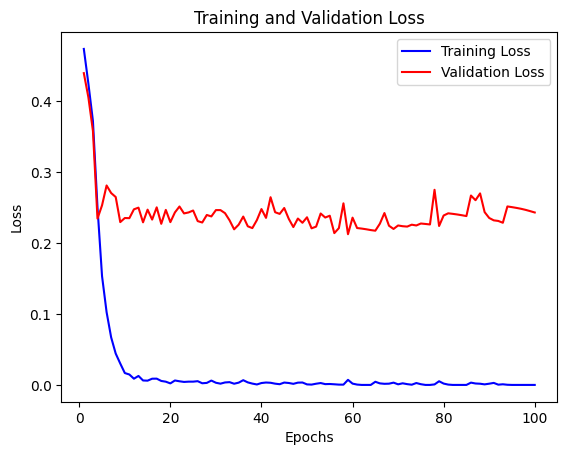

In [404]:
# Построение графика
epochs = range(1, len(losses) + 1)

plt.plot(epochs, losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [405]:
# # Визуализация потерь
# epochs = range(1, len(losses) + 1)
# plt.plot(epochs, losses, 'b', label='Training loss')
# plt.title('Training loss over epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [406]:
# Функция для тестирования модели
def test_model(model, triplets, loss_fn, device='cuda'):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for anchor_file, positive_file, negative_file in triplets:
            anchor = extract_mel_spectrogram(anchor_file).unsqueeze(0).to(device)
            positive = extract_mel_spectrogram(positive_file).unsqueeze(0).to(device)
            negative = extract_mel_spectrogram(negative_file).unsqueeze(0).to(device)
            
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)
            
            loss = loss_fn(anchor_embed, positive_embed, negative_embed)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(triplets)
    print(f"Средние потери на тестовом наборе: {avg_loss}")

In [407]:
# Функция для оценки точности модели
from torch.nn.functional import cosine_similarity

def evaluate_speaker_verification(model, triplets, device='cuda'):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for anchor_file, positive_file, negative_file in triplets:
            anchor = extract_mel_spectrogram(anchor_file).unsqueeze(0).to(device)
            positive = extract_mel_spectrogram(positive_file).unsqueeze(0).to(device)
            negative = extract_mel_spectrogram(negative_file).unsqueeze(0).to(device)
            
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)
            
            pos_similarity = cosine_similarity(anchor_embed, positive_embed)
            neg_similarity = cosine_similarity(anchor_embed, negative_embed)
            
            if pos_similarity > neg_similarity:
                correct += 1
            total += 1
    
    accuracy = correct / total
    print(f"Точность модели: {accuracy * 100:.2f}%")

In [408]:
# Оценка модели на валидационном наборе
test_model(model, test_triplets, triplet_loss, device=device)
evaluate_speaker_verification(model, test_triplets, device=device)

Средние потери на тестовом наборе: 0.2512935837474438
Точность модели: 78.72%


In [409]:
# Сохранение модели
torch.save(model.state_dict(), 'cnn_speaker_verification.pth')